# Advection-Diffusion

In this example, we will learn how to perform an advection-diffusion simulation of a given chemical species through a `Cubic` network. The algorithm can be applied to more complex networks in the same manner as described in this example. For the sake of simplicity, a one layer 3D cubic network is used here. On `OpenPNM`, 4 different space discretization schemes for the advection-diffusion problem are available and consist of:

1. Upwind
2. Hybrid
3. Powerlaw
4. Exponential

Depending on the Peclet number characterizing the transport (ratio of advective to diffusive fluxes), the solutions obtained using these schemes may differ. In order to achive a high numerical accuracy, the user should use either the `powerlaw` or the `exponential` schemes.

## Generating network
First, we need to generate a `Cubic` network. For now, we stick to a one layer 3d network, but you might as well try more complex networks!

In [1]:
import numpy as np
import openpnm as op
np.random.seed(10)
%matplotlib inline
ws = op.Workspace()
ws.settings["loglevel"] = 40
np.set_printoptions(precision=5)
net = op.network.Cubic(shape=[1, 20, 30], spacing=1e-4)

## Adding geometry
Next, we need to add a geometry to the generated network. A geometry contains information about size of the pores/throats in a network. `OpenPNM` has tons of prebuilt geometries that represent the microstructure of different materials such as Toray090 carbon papers, sand stone, electrospun fibers, etc. For now, we stick to a sample geometry called `StickAndBall` that assigns random values to pore/throat diameters.

In [2]:
geom = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)

## Adding phase
Next, we need to add a phase to our simulation. A phase object(s) contain(s) thermophysical information about the working fluid(s) in the simulation. `OpenPNM` has tons of prebuilt phases as well! For this simulation, we use air as our working fluid.

In [3]:
air = op.phases.Air(network=net)

## Adding physics
Finally, we need to add a physics. A physics object contains information about the working fluid in the simulation that depend on the geometry of the network. A good example is diffusive conductance, which not only depends on the thermophysical properties of the working fluid, but also depends on the geometry of pores/throats.

In [4]:
phys_air = op.physics.Standard(network=net, phase=air, geometry=geom)

# Performing Stokes flow

Note that the advection diffusion algorithm assumes that velocity field is given. Naturally, we solve Stokes flow inside a pore network model to obtain the pressure field, and eventually the velocity field. Therefore, we need to run the `StokesFlow` algorithm prior to running our advection diffusion. There's a separate tutorial on how to run `StokesFlow` in `OpenPNM`, but here's a simple code snippet that does the job for us.

In [5]:
sf = op.algorithms.StokesFlow(network=net, phase=air)
sf.set_value_BC(pores=net.pores('left'), values=200.0)
sf.set_value_BC(pores=net.pores('right'), values=0.0)
sf.run();

It is essential that you attach the results from `StokesFlow` (i.e. pressure field) to the corresponding phase, since the results from any algorithm in `OpenPNM` are by default only attached to the algorithm object (in this case to `sf`). Here's how you can update your phase:

In [6]:
air.update(sf.results())

## Performing advection-diffusion

Now that everything is set up, it's time to perform our advection-diffusion simulation. For this purpose, we need to add corresponding algorithm to our simulation. As mentioned above, `OpenPNM` supports 4 different discretizations that may be used with the `AdvectionDiffusion` and `Dispersion` algorithms.
Setting the discretization scheme can be performed when defining the physics model as follows:

In [7]:
mod = op.models.physics.ad_dif_conductance.ad_dif
phys_air.add_model(propname='throat.ad_dif_conductance', model=mod, s_scheme='powerlaw')

Then, the advection-diffusion algorithm is defined by:

In [8]:
ad = op.algorithms.AdvectionDiffusion(network=net, phase=air)

Note that `network` and `phase` are required parameters for pretty much every algorithm we add, since we need to specify on which network and for which phase do we want to run the algorithm.

Note that you can also specify the discretization scheme by modifying the `settings` of our `AdvectionDiffusion` algorithm. You can choose between `upwind`, `hybrid`, `powerlaw`, and `exponential`.
It is important to note that the scheme specified within the algorithm's settings is only used when calling the `rate` method for post processing.

## Adding boundary conditions
Next, we need to add some boundary conditions to the simulation. By default, `OpenPNM` assumes zero flux for the boundary pores.

In [9]:
inlet  = net.pores('left') 
outlet = net.pores(['right', 'top', 'bottom'])
ad.set_value_BC(pores=inlet, values=100.0)
ad.set_value_BC(pores=outlet, values=0.0)

`set_value_BC` applies the so-called "Dirichlet" boundary condition to the specified pores. Note that unless you want to apply a single value to all of the specified pores (like we just did), you must pass a list (or `ndarray`) as the `values` parameter.

## Running the algorithm
Now, it's time to run the algorithm. This is done by calling the `run` method attached to the algorithm object.

In [10]:
ad.run();

# Post processing
When an algorithm is successfully run, the results are attached to the same object. To access the results, you need to know the quantity for which the algorithm was solving. For instance, `AdvectionDiffusion` solves for the quantity `pore.concentration`, which is somewhat intuitive. However, if you ever forget it, or wanted to manually check the quantity, you can take a look at the algorithm `settings`:

In [11]:
print(ad.settings)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
key                                 value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
phase                               phase_01
conductance                         throat.ad_dif_conductance
quantity                            pore.concentration
solver_family                       scipy
solver_type                         spsolve
solver_preconditioner               jacobi
solver_tol                          1e-08
solver_atol                         None
solver_rtol                         None
solver_maxiter                      5000
iterative_props                     ['throat.ad_dif_conductance']
cache_A                             True
cache_b                             True
gui                                 {'setup': {'phase': None, 'quantity': '', 'conductance': ''}, 'set_rate_BC': {'pores': None, 'values': None}, 'set_value_BC': {'pores': None, 'values': None}, '

Now that we know the quantity for which `AdvectionDiffusion` was solved, let's take a look at the results:

In [12]:
c = ad['pore.concentration']

## Heatmap
Since the network is 2d, we can simply reshape the results in form of a 2d array similar to the shape of the network and plot the heatmap of it using `matplotlib`.

In [13]:
print('Network shape:', net._shape)
c2d = c.reshape((net._shape))

Network shape: (1, 20, 30)


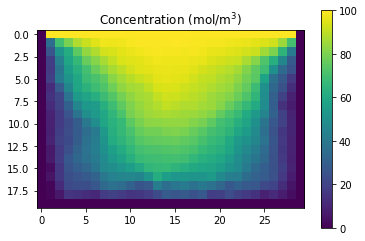

In [14]:
#NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt
plt.imshow(c2d[0,:,:]);
plt.title('Concentration (mol/m$^3$)');
plt.colorbar();